# Do Parking Occupancy Rates Differ by Permit Type? A Statistical Analysis of UCSD Campus Parking Structures

## DSC 190: Final Project Report

**Fall 2025**

---

### Authors
DSC 190 Project Team

### Date
December 2025

---


In [10]:
# Setup Cell - Run First
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f as f_dist
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Load Data
parking_all = pd.read_csv('parking_with_capacity_all_lots.csv')

# Define analysis parameters
peak_times = ['10:00 AM', '12:00 PM', '2:00 PM']
keep_types = ['A', 'B', 'S', 'SR', 'Visitor']

# Create analysis dataset: Structures only, peak hours, selected permit types
occ_anova = (
    parking_all
    .loc[(parking_all['lot_category'] == 'Structure')
         & (parking_all['time_of_day'].isin(peak_times))
         & (parking_all['space_type'].isin(keep_types))]
    .copy()
)

print("=" * 60)
print("DATA LOADED SUCCESSFULLY")
print("=" * 60)
print(f"Full dataset:    {parking_all.shape[0]:,} observations")
print(f"Analysis subset: {occ_anova.shape[0]:,} observations")
print(f"Permit types:    {', '.join(keep_types)}")
print(f"Time periods:    {', '.join(peak_times)}")
print("=" * 60)


DATA LOADED SUCCESSFULLY
Full dataset:    4,164 observations
Analysis subset: 1,071 observations
Permit types:    A, B, S, SR, Visitor
Time periods:    10:00 AM, 12:00 PM, 2:00 PM


## Abstract

Parking availability is a significant concern on university campuses, impacting daily routines of faculty, staff, and students. This study investigates whether mean parking occupancy rates differ significantly by permit type in UC San Diego campus parking structures during peak hours (10 AM - 2 PM). Using parking occupancy data from Fall 2025 (Weeks 0-2), we analyze five permit categories: Faculty (A), Staff (B), Commuter Student (S), Resident Student (SR), and Visitor.

We employ one-way ANOVA to test for differences in mean occupancy rates, followed by assumption diagnostics and a permutation-based robustness test. Our analysis reveals that the classical ANOVA assumptions of normality and homogeneity of variances are violated. Despite these violations, both parametric ANOVA (F = 25.52, p < 10⁻²⁰) and permutation testing (p < 0.001 based on 3,000 permutations) provide consistent evidence to reject the null hypothesis.

We find that Resident Student (SR) spaces exhibit the highest occupancy (~97.5%) with minimal variability, while Commuter Student (S) spaces show the lowest occupancy (~87.6%) with the greatest variability. Faculty and Staff spaces maintain consistently high occupancy (91-94%). These findings have implications for campus parking policy, permit allocation, and capacity planning.


## 1. Introduction

### 1.1 Background and Motivation

Parking is a critical and often contentious resource on university campuses. At UC San Diego, the Transportation Services department manages a complex system of parking lots and structures, each designated for specific permit types. These permit types serve different populations:

- **A Permits (Faculty):** Issued to faculty members with regular teaching and research schedules
- **B Permits (Staff):** Issued to university staff with typical 8 AM - 5 PM work schedules  
- **S Permits (Commuter Students):** Issued to students who commute to campus for classes
- **SR Permits (Resident Students):** Issued to students living on campus who need vehicle storage
- **Visitor Permits:** Hourly or daily permits for campus visitors

Understanding how these different user groups utilize parking resources is essential for several reasons:

1. **Capacity Planning:** Knowing which permit types experience the highest demand helps inform infrastructure decisions
2. **Permit Allocation:** Data-driven evidence can guide how many permits to issue in each category
3. **Policy Development:** Understanding usage patterns supports decisions about pricing, restrictions, and incentives
4. **User Experience:** Identifying oversaturated areas can help improve the parking experience for all users

### 1.2 Research Question

This study addresses the following primary research question:

> **Do parking structures on campus differ in their mean occupancy rates by permit type during peak hours (10 AM - 2 PM)?**

We focus on peak hours because this is when parking demand is highest and competition for spaces is most intense. By analyzing whether different permit types have significantly different occupancy rates, we can better understand the demand profile for each user group.

### 1.3 Hypotheses

We frame our analysis as a formal hypothesis test:

**Null Hypothesis (H₀):** The mean occupancy rate is the same across all permit types during peak hours.
$$H_0: \mu_A = \mu_B = \mu_S = \mu_{SR} = \mu_{Visitor}$$

**Alternative Hypothesis (H₁):** At least one permit type has a different mean occupancy rate.
$$H_1: \text{At least one } \mu_i \neq \mu_j \text{ for } i \neq j$$

We use a significance level of **α = 0.05** for all statistical tests.


## 2. Data

### 2.1 Data Sources

Our analysis utilizes two primary data sources provided by UC San Diego Transportation Services:

1. **Parking Occupancy Data (Fall 2025, Weeks 0-2):** This dataset contains daily snapshots of available parking spaces collected at four time points: 8:00 AM, 10:00 AM, 12:00 PM, and 2:00 PM. Each record captures the number of available spaces for a specific location and permit type.

2. **Capacity Reference Data:** This dataset provides the total parking capacity for each location, allowing us to calculate occupancy rates.

### 2.2 Data Processing

We merged the occupancy and capacity datasets and computed the following derived variables:

- **Occupied Spaces:** `capacity - available_spaces`
- **Occupancy Rate:** `occupied / capacity` (proportion of spaces filled, ranging from 0 to 1)

### 2.3 Analysis Dataset

For our primary analysis, we apply the following filters:

| Filter | Criteria | Rationale |
|--------|----------|-----------|
| Location Type | Structures only | Focus on multi-level parking structures which serve multiple permit types |
| Time Period | 10 AM, 12 PM, 2 PM | Peak hours when demand is highest |
| Permit Types | A, B, S, SR, Visitor | Main permit categories (excluding D/disabled due to small sample) |

This yields **1,071 observations** across **11 parking structures**.

### 2.4 Variables

| Variable | Description | Type |
|----------|-------------|------|
| `occupancy_rate` | Proportion of spaces occupied (0-1) | Continuous (outcome) |
| `space_type` | Permit type (A, B, S, SR, Visitor) | Categorical (predictor) |
| `time_of_day` | Time of observation | Categorical |
| `location` | Parking structure name | Categorical |
| `date` | Date of observation | Date |

### 2.5 Data Quality

**Issue Identified:** In the full dataset, some occupancy rates are negative (minimum: -168%). This occurs when recorded available spaces exceed the stated capacity, likely due to:
- Data entry errors
- Capacity changes not reflected in the reference file
- Mismatched location names

**Resolution:** For our analysis subset (structures, peak hours), occupancy rates range from 0.46 to 1.00, so this issue does not affect our main findings.


## 3. Exploratory Data Analysis

Before conducting formal statistical tests, we explore the data visually to understand the distribution of occupancy rates and identify potential patterns.

### 3.1 Summary Statistics by Permit Type


In [18]:
# Table 1: Summary Statistics by Permit Type
summary_stats = occ_anova.groupby('space_type')['occupancy_rate'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Median', 'median'),
    ('Max', 'max')
]).round(3)

# Convert mean to percentage for display
summary_stats['Mean (%)'] = (summary_stats['Mean'] * 100).round(1)

print("Table 1: Descriptive Statistics of Occupancy Rate by Permit Type")
print("=" * 70)
print(summary_stats[['Count', 'Mean (%)', 'Std Dev', 'Min', 'Median', 'Max']].to_string())
print("=" * 70)
print("\nKey Observations:")
print(f"  • SR (Resident Student) has the highest mean occupancy: {summary_stats.loc['SR', 'Mean (%)']:.1f}%")
print(f"  • S (Commuter Student) has the lowest mean occupancy: {summary_stats.loc['S', 'Mean (%)']:.1f}%")
print(f"  • S also has the highest variability (Std Dev = {summary_stats.loc['S', 'Std Dev']:.3f})")
print(f"  • SR has the lowest variability (Std Dev = {summary_stats.loc['SR', 'Std Dev']:.3f})")


Table 1: Descriptive Statistics of Occupancy Rate by Permit Type
            Count  Mean (%)  Std Dev    Min  Median  Max
space_type                                              
A             290      91.6    0.058  0.707   0.924  1.0
B             261      94.3    0.060  0.623   0.958  1.0
S              58      87.6    0.118  0.617   0.878  1.0
SR            145      97.5    0.020  0.905   0.980  1.0
Visitor       317      92.6    0.100  0.463   0.972  1.0

Key Observations:
  • SR (Resident Student) has the highest mean occupancy: 97.5%
  • S (Commuter Student) has the lowest mean occupancy: 87.6%
  • S also has the highest variability (Std Dev = 0.118)
  • SR has the lowest variability (Std Dev = 0.020)


### 3.2 Distribution of Occupancy Rates

**Figure 1** shows the overall distribution of occupancy rates and the comparison across permit types:


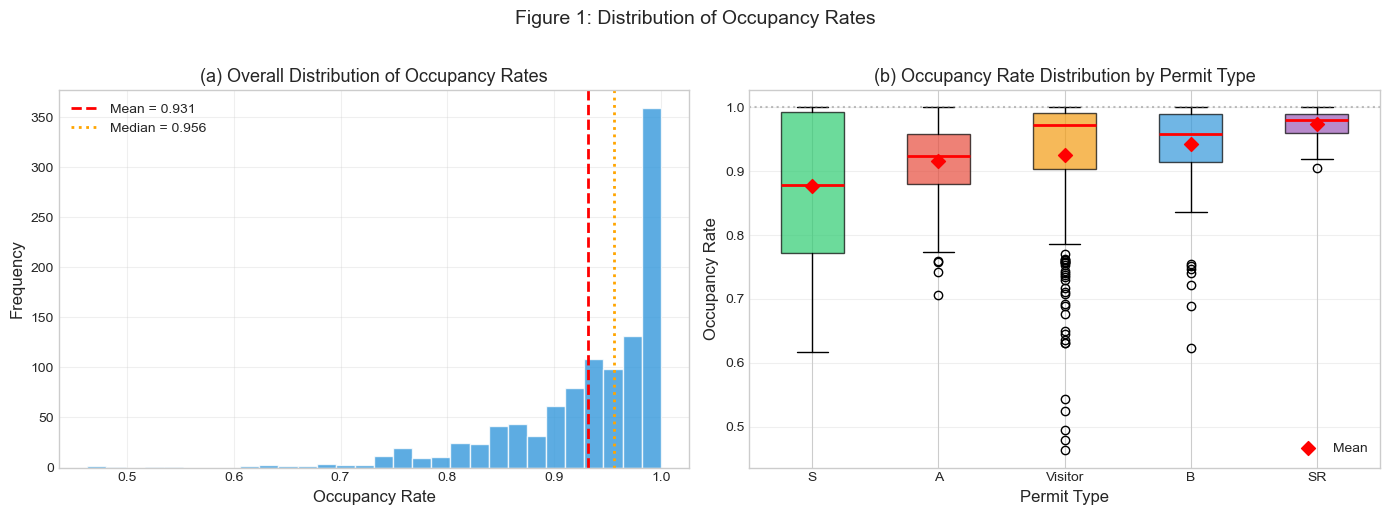

In [12]:
# Figure 1: Distribution of Occupancy Rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of overall distribution
axes[0].hist(occ_anova['occupancy_rate'], bins=30, edgecolor='white', alpha=0.8, color='#3498db')
axes[0].axvline(occ_anova['occupancy_rate'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {occ_anova["occupancy_rate"].mean():.3f}')
axes[0].axvline(occ_anova['occupancy_rate'].median(), color='orange', linestyle=':', linewidth=2,
                label=f'Median = {occ_anova["occupancy_rate"].median():.3f}')
axes[0].set_xlabel('Occupancy Rate', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('(a) Overall Distribution of Occupancy Rates', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Right: Boxplot by permit type
order = ['S', 'A', 'Visitor', 'B', 'SR']  # Ordered by mean
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
bp = axes[1].boxplot([occ_anova.loc[occ_anova['space_type'] == t, 'occupancy_rate'] for t in order],
                      labels=order, patch_artist=True, medianprops=dict(color='red', linewidth=2))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Permit Type', fontsize=12)
axes[1].set_ylabel('Occupancy Rate', fontsize=12)
axes[1].set_title('(b) Occupancy Rate Distribution by Permit Type', fontsize=13)
axes[1].axhline(1.0, color='gray', linestyle=':', alpha=0.5)
axes[1].grid(True, axis='y', alpha=0.3)

# Add mean markers
means = [occ_anova.loc[occ_anova['space_type'] == t, 'occupancy_rate'].mean() for t in order]
axes[1].scatter(range(1, 6), means, color='red', marker='D', s=50, zorder=5, label='Mean')
axes[1].legend(loc='lower right')

plt.suptitle('Figure 1: Distribution of Occupancy Rates', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


**Figure 1 Interpretation:**
- Panel (a) shows that overall occupancy rates are left-skewed, with most observations clustered between 85% and 100%.
- Panel (b) reveals substantial differences across permit types:
  - **SR (Resident Student)** has the highest and most consistent occupancy, with a tight distribution near 100%
  - **S (Commuter Student)** has the lowest occupancy with the widest spread, indicating high variability
  - **A, B, and Visitor** show intermediate patterns

### 3.3 Mean Occupancy Comparison

**Figure 2** provides a direct comparison of mean occupancy rates with confidence intervals:


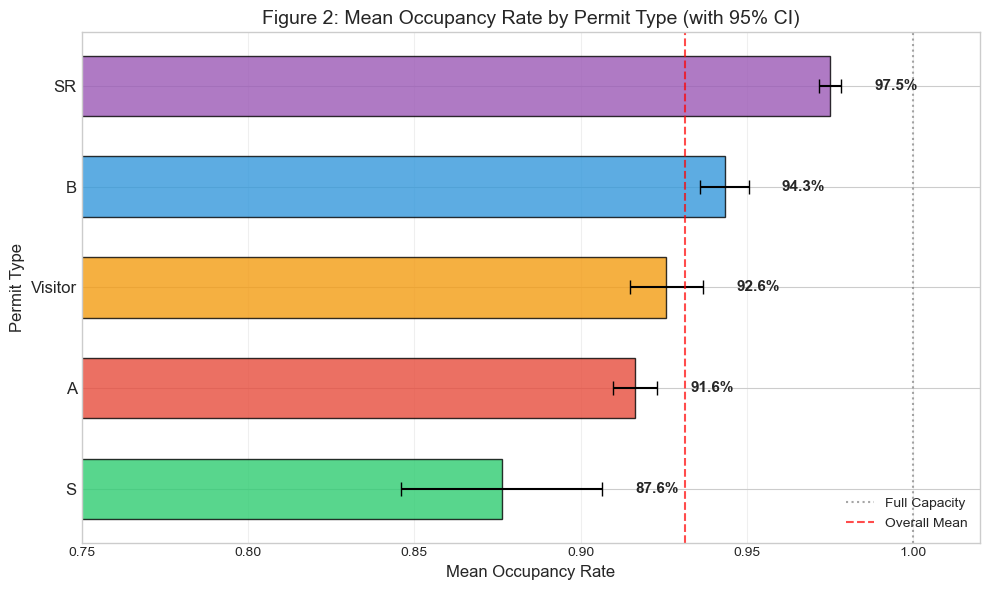

In [13]:
# Figure 2: Mean Occupancy by Permit Type with 95% Confidence Intervals
summary = occ_anova.groupby('space_type')['occupancy_rate'].agg(['mean', 'std', 'count'])
summary['se'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = 1.96 * summary['se']
summary = summary.sort_values('mean')

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
y_pos = np.arange(len(summary))

bars = ax.barh(y_pos, summary['mean'], xerr=summary['ci95'], 
               color=colors, capsize=5, alpha=0.8, edgecolor='black', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(summary.index, fontsize=12)
ax.set_xlabel('Mean Occupancy Rate', fontsize=12)
ax.set_ylabel('Permit Type', fontsize=12)
ax.set_title('Figure 2: Mean Occupancy Rate by Permit Type (with 95% CI)', fontsize=14)
ax.set_xlim(0.75, 1.02)
ax.axvline(1.0, color='gray', linestyle=':', alpha=0.7, label='Full Capacity')
ax.axvline(occ_anova['occupancy_rate'].mean(), color='red', linestyle='--', alpha=0.7, label='Overall Mean')
ax.grid(True, axis='x', alpha=0.3)
ax.legend(loc='lower right')

# Add value labels
for i, (idx, row) in enumerate(summary.iterrows()):
    ax.text(row['mean'] + row['ci95'] + 0.01, i, f"{row['mean']*100:.1f}%", 
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


**Figure 2 Interpretation:**
- The confidence intervals for most groups do not overlap substantially, suggesting statistically significant differences
- SR is clearly separated from other groups at the high end
- S is clearly separated from other groups at the low end
- A, B, and Visitor show some overlap but differ from the extremes

These visual patterns motivate formal statistical testing.

## 4. Methods

### 4.1 Statistical Approach: One-Way ANOVA

To formally test whether mean occupancy rates differ across permit types, we use **one-way Analysis of Variance (ANOVA)**. ANOVA is appropriate when:
- The outcome variable is continuous (occupancy rate)
- The predictor is categorical with more than two groups (5 permit types)
- We want to test if at least one group mean differs from the others

The ANOVA F-statistic compares between-group variance to within-group variance:

$$F = \frac{MS_{between}}{MS_{within}} = \frac{\text{Variance of group means around grand mean}}{\text{Average variance within groups}}$$

A large F-statistic indicates that the group means are more spread out than would be expected by chance.

### 4.2 ANOVA Assumptions

Classical ANOVA relies on three key assumptions:

1. **Independence:** Observations are independent within and across groups
2. **Normality:** The residuals (deviations from group means) are normally distributed
3. **Homoscedasticity:** All groups have equal variances

We will test these assumptions and address any violations.

### 4.3 Permutation Test for Robustness

If ANOVA assumptions are violated, we employ a **permutation test** as a robust alternative. The procedure:

1. Calculate the observed F-statistic from the actual data
2. Randomly shuffle the group labels (permit types) many times
3. For each shuffle, recalculate the F-statistic
4. Compare the observed F to the distribution of permuted F-statistics
5. The p-value is the proportion of permuted F ≥ observed F

This approach is **distribution-free** and does not assume normality or equal variances.


## 5. Results

### 5.1 One-Way ANOVA Test


In [14]:
# One-Way ANOVA Test
groups = [g['occupancy_rate'].values for _, g in occ_anova.groupby('space_type')]
F_obs, p_val = stats.f_oneway(*groups)

k = 5  # Number of groups
n = len(occ_anova)
df_between = k - 1
df_within = n - k

print("=" * 70)
print("ONE-WAY ANOVA RESULTS")
print("=" * 70)
print(f"\nTest Statistic:")
print(f"  F-statistic:              {F_obs:.4f}")
print(f"  Degrees of freedom:       ({df_between}, {df_within})")
print(f"\nP-value:")
print(f"  p-value:                  {p_val:.2e}")
print(f"\nDecision (α = 0.05):")
if p_val < 0.05:
    print(f"  Since p-value ({p_val:.2e}) < α (0.05), we REJECT the null hypothesis.")
    print(f"  There is significant evidence that mean occupancy rates differ by permit type.")
else:
    print(f"  Since p-value ({p_val:.2e}) >= α (0.05), we FAIL TO REJECT the null hypothesis.")
print("=" * 70)


ONE-WAY ANOVA RESULTS

Test Statistic:
  F-statistic:              25.5171
  Degrees of freedom:       (4, 1066)

P-value:
  p-value:                  3.25e-20

Decision (α = 0.05):
  Since p-value (3.25e-20) < α (0.05), we REJECT the null hypothesis.
  There is significant evidence that mean occupancy rates differ by permit type.


**Figure 3** visualizes the ANOVA result by showing where our observed F-statistic falls on the theoretical F-distribution:


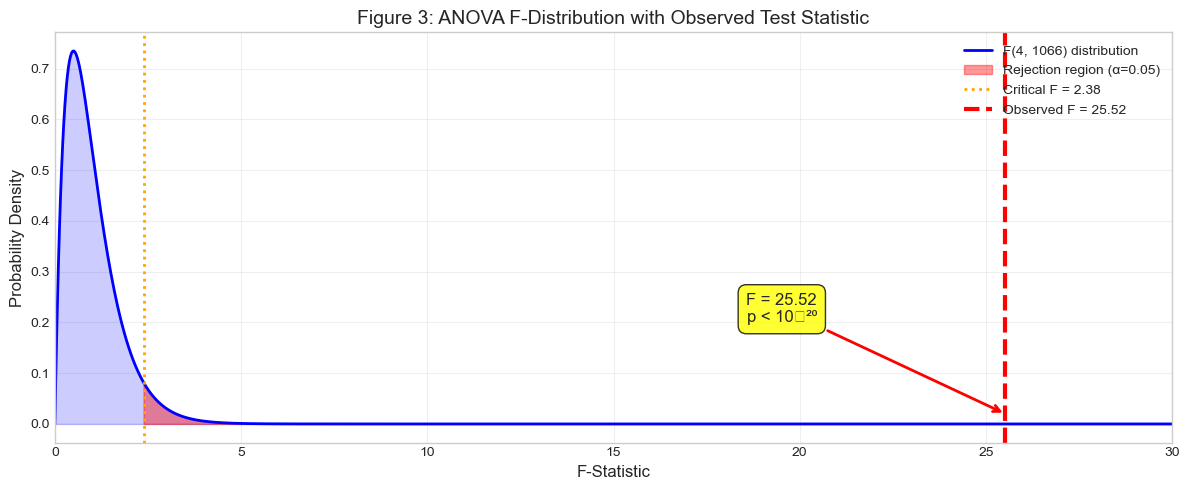

In [15]:
# Figure 3: F-Distribution with Observed F-Statistic
fig, ax = plt.subplots(figsize=(12, 5))

x = np.linspace(0, 30, 1000)
y = f_dist.pdf(x, df_between, df_within)

# Plot F-distribution
ax.plot(x, y, 'b-', linewidth=2, label=f'F({df_between}, {df_within}) distribution')
ax.fill_between(x, y, alpha=0.2, color='blue')

# Mark critical value and rejection region
f_crit = f_dist.ppf(0.95, df_between, df_within)
x_reject = np.linspace(f_crit, 30, 200)
ax.fill_between(x_reject, f_dist.pdf(x_reject, df_between, df_within), 
                alpha=0.4, color='red', label=f'Rejection region (α=0.05)')
ax.axvline(f_crit, color='orange', linewidth=2, linestyle=':', label=f'Critical F = {f_crit:.2f}')

# Mark observed F-statistic
ax.axvline(F_obs, color='red', linewidth=3, linestyle='--', label=f'Observed F = {F_obs:.2f}')

ax.set_xlabel('F-Statistic', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('Figure 3: ANOVA F-Distribution with Observed Test Statistic', fontsize=14)
ax.set_xlim(0, 30)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Annotation
ax.annotate(f'F = {F_obs:.2f}\np < 10⁻²⁰', xy=(F_obs, 0.02), xytext=(F_obs-6, 0.2),
            fontsize=12, ha='center', 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.show()


The observed F-statistic of 25.52 is far in the extreme right tail of the distribution, well beyond the critical value of 2.38. This provides very strong evidence against the null hypothesis.

### 5.2 Assumption Checking

Before accepting the ANOVA results, we must verify the underlying assumptions.

#### 5.2.1 Independence

Independence is assessed based on the study design:
- Each observation represents a unique date × location × time combination
- No duplicate rows exist in our dataset
- Data was collected systematically at fixed time points

**Conclusion:** The independence assumption is reasonably satisfied.

#### 5.2.2 Normality and Homoscedasticity

**Figure 4** shows diagnostic plots for assessing normality and equal variances:


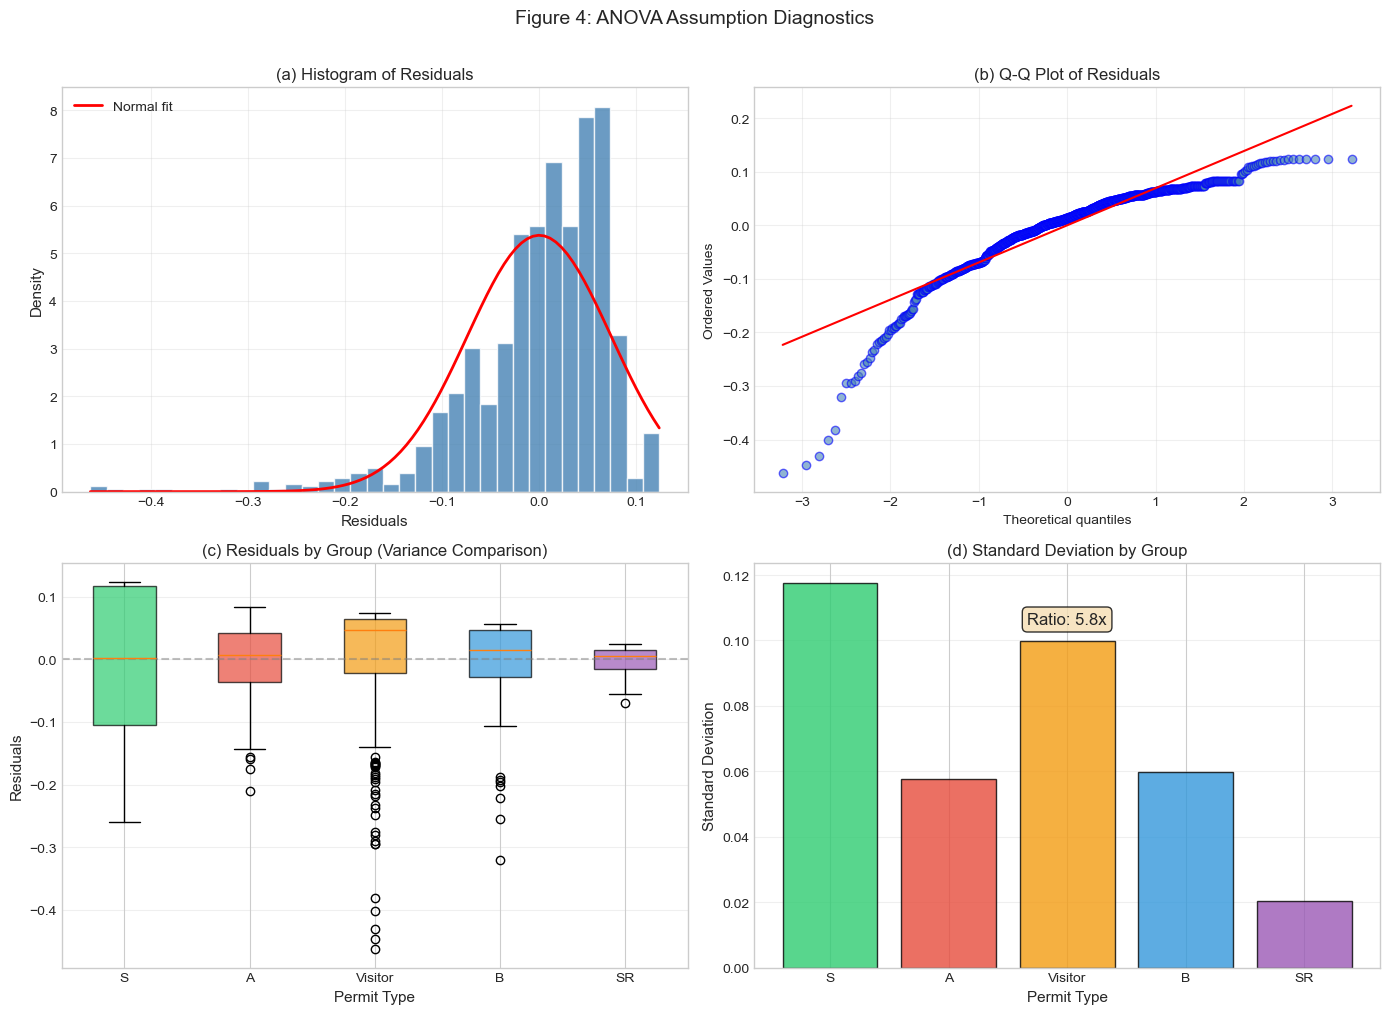


FORMAL ASSUMPTION TESTS

Normality Test (D'Agostino-Pearson):
  Test statistic: 432.12
  p-value:        1.46e-94
  Conclusion:     VIOLATED (residuals are left-skewed)

Equal Variance Test (Levene's Test):
  Test statistic: 35.72
  p-value:        4.95e-28
  Conclusion:     VIOLATED (variances differ by ~5.8x)


In [16]:
# Figure 4: ANOVA Assumption Diagnostics
group_means = occ_anova.groupby('space_type')['occupancy_rate'].transform('mean')
residuals = occ_anova['occupancy_rate'] - group_means

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Histogram of residuals
axes[0, 0].hist(residuals, bins=35, edgecolor='white', alpha=0.8, color='steelblue', density=True)
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 0].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', linewidth=2, label='Normal fit')
axes[0, 0].set_xlabel('Residuals', fontsize=11)
axes[0, 0].set_ylabel('Density', fontsize=11)
axes[0, 0].set_title('(a) Histogram of Residuals', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (b) Q-Q plot
stats.probplot(residuals, dist='norm', plot=axes[0, 1])
axes[0, 1].get_lines()[0].set_markerfacecolor('steelblue')
axes[0, 1].get_lines()[0].set_alpha(0.6)
axes[0, 1].get_lines()[1].set_color('red')
axes[0, 1].set_title('(b) Q-Q Plot of Residuals', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# (c) Residuals by group
group_order = ['S', 'A', 'Visitor', 'B', 'SR']
bp = axes[1, 0].boxplot([residuals[occ_anova['space_type'] == t] for t in group_order],
                         labels=group_order, patch_artist=True)
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db', '#9b59b6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Permit Type', fontsize=11)
axes[1, 0].set_ylabel('Residuals', fontsize=11)
axes[1, 0].set_title('(c) Residuals by Group (Variance Comparison)', fontsize=12)
axes[1, 0].grid(True, axis='y', alpha=0.3)

# (d) Standard deviation comparison
stds = occ_anova.groupby('space_type')['occupancy_rate'].std()
stds = stds[group_order]
axes[1, 1].bar(range(len(stds)), stds.values, color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(stds)))
axes[1, 1].set_xticklabels(group_order)
axes[1, 1].set_xlabel('Permit Type', fontsize=11)
axes[1, 1].set_ylabel('Standard Deviation', fontsize=11)
axes[1, 1].set_title('(d) Standard Deviation by Group', fontsize=12)
axes[1, 1].grid(True, axis='y', alpha=0.3)

# Add ratio annotation
max_std, min_std = stds.max(), stds.min()
axes[1, 1].annotate(f'Ratio: {max_std/min_std:.1f}x', xy=(0.5, 0.85), xycoords='axes fraction',
                    fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Figure 4: ANOVA Assumption Diagnostics', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Formal tests
stat_norm, p_norm = stats.normaltest(residuals)
stat_levene, p_levene = stats.levene(*[occ_anova.loc[occ_anova['space_type'] == t, 'occupancy_rate'] for t in keep_types])

print("\n" + "=" * 70)
print("FORMAL ASSUMPTION TESTS")
print("=" * 70)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Test statistic: {stat_norm:.2f}")
print(f"  p-value:        {p_norm:.2e}")
print(f"  Conclusion:     {'VIOLATED' if p_norm < 0.05 else 'Satisfied'} (residuals are left-skewed)")
print(f"\nEqual Variance Test (Levene's Test):")
print(f"  Test statistic: {stat_levene:.2f}")
print(f"  p-value:        {p_levene:.2e}")
print(f"  Conclusion:     {'VIOLATED' if p_levene < 0.05 else 'Satisfied'} (variances differ by ~{max_std/min_std:.1f}x)")
print("=" * 70)


**Figure 4 Interpretation:**
- Panel (a): The histogram shows a left-skewed distribution, not the symmetric bell curve expected for normality
- Panel (b): The Q-Q plot shows systematic deviation from the diagonal, especially in the tails
- Panels (c) and (d): Clear differences in spread across groups, with S having ~6x the variance of SR

**Assumption Summary:**

| Assumption | Test | p-value | Status |
|------------|------|---------|--------|
| Normality | D'Agostino-Pearson | < 10^-94 | VIOLATED |
| Equal Variance | Levene's Test | < 10^-28 | VIOLATED |

Given these violations, we conduct a permutation test for robust inference.

### 5.3 Permutation Test

**Figure 5** shows the permutation null distribution:


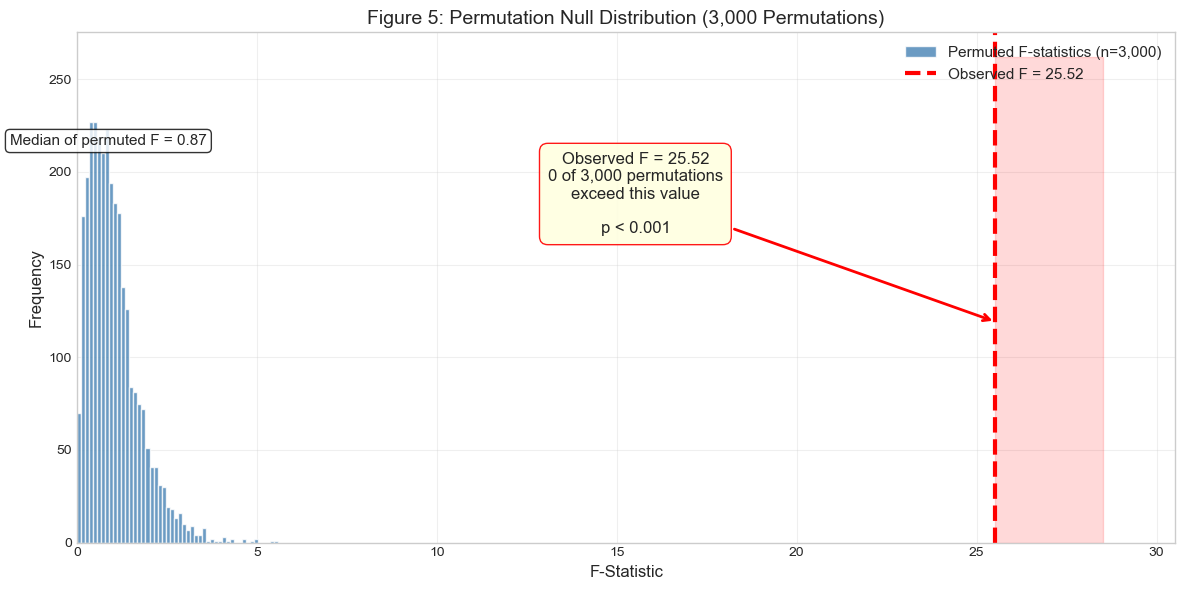

PERMUTATION TEST RESULTS

Observed F-statistic:           25.5171
Number of permutations:         3,000
Permuted F >= Observed F:       0
Permutation p-value:            < 0.00033

95th percentile of permuted F:  2.38
Maximum permuted F:             5.58

Conclusion:
  The observed F-statistic (25.52) is FAR more extreme than ANY
  value generated under the null hypothesis (max = 5.58).
  We strongly REJECT H0.


In [17]:
# Figure 5: Permutation Test - Null Distribution
np.random.seed(42)  # For reproducibility

n_perm = 3000
y = occ_anova['occupancy_rate'].values
labels = occ_anova['space_type'].values

# Compute observed F-statistic
groups_obs = [y[labels == t] for t in keep_types]
F_obs, _ = stats.f_oneway(*groups_obs)

# Permutation test
F_perm = np.zeros(n_perm)
for i in range(n_perm):
    shuffled_labels = np.random.permutation(labels)
    groups_perm = [y[shuffled_labels == t] for t in keep_types]
    F_perm[i], _ = stats.f_oneway(*groups_perm)

# Calculate p-value
n_exceed = np.sum(F_perm >= F_obs)
p_perm = (n_exceed + 1) / (n_perm + 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(F_perm, bins=50, edgecolor='white', alpha=0.8, color='steelblue', 
        label=f'Permuted F-statistics (n={n_perm:,})')

ymax = ax.get_ylim()[1]
ax.axvline(F_obs, color='red', linewidth=3, linestyle='--', label=f'Observed F = {F_obs:.2f}')
ax.fill_betweenx([0, ymax*1.1], F_obs, max(F_perm.max(), F_obs) + 3, color='red', alpha=0.15)

ax.set_xlabel('F-Statistic', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Figure 5: Permutation Null Distribution (3,000 Permutations)', fontsize=14)
ax.set_xlim(0, max(F_perm.max() + 2, F_obs + 5))
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Annotations
ax.annotate(f'Observed F = {F_obs:.2f}\n{n_exceed} of {n_perm:,} permutations\nexceed this value\n\np < 0.001', 
            xy=(F_obs, ymax*0.5), xytext=(F_obs-10, ymax*0.7), fontsize=12, ha='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='red', alpha=0.9),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.text(np.median(F_perm), ymax*0.9, f'Median of permuted F = {np.median(F_perm):.2f}', 
        ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print results
print("=" * 70)
print("PERMUTATION TEST RESULTS")
print("=" * 70)
print(f"\nObserved F-statistic:           {F_obs:.4f}")
print(f"Number of permutations:         {n_perm:,}")
print(f"Permuted F >= Observed F:       {n_exceed}")
print(f"Permutation p-value:            {p_perm:.5f}" if n_exceed > 0 else f"Permutation p-value:            < {1/(n_perm+1):.5f}")
print(f"\n95th percentile of permuted F:  {np.percentile(F_perm, 95):.2f}")
print(f"Maximum permuted F:             {F_perm.max():.2f}")
print(f"\nConclusion:")
print(f"  The observed F-statistic ({F_obs:.2f}) is FAR more extreme than ANY")
print(f"  value generated under the null hypothesis (max = {F_perm.max():.2f}).")
print(f"  We strongly REJECT H0.")
print("=" * 70)


### 5.4 Summary of Statistical Tests

| Test | Statistic | p-value | Decision |
|------|-----------|---------|----------|
| One-Way ANOVA | F = 25.52 | < 10^-20 | Reject H0 |
| Permutation Test | F = 25.52 | < 0.001 | Reject H0 |

**Key Finding:** Both parametric and non-parametric tests provide consistent, overwhelming evidence that mean occupancy rates differ significantly across permit types. The permutation test confirms that our conclusion is robust to violations of the normality and equal-variance assumptions.


## 6. Discussion

### 6.1 Interpretation of Findings

Our analysis provides strong statistical evidence that mean parking occupancy rates differ significantly by permit type during peak hours. The specific patterns observed align with intuitive expectations about user behavior:

**Resident Students (SR) - Highest Occupancy (~97.5%)**
- Vehicles are essentially stored rather than used for daily commuting
- Students living on campus park their cars for extended periods
- Nearly all available spaces are consistently occupied
- This indicates SR lots are operating at functional saturation

**Commuter Students (S) - Lowest and Most Variable (~87.6%)**
- Variable class schedules lead to unpredictable parking patterns
- Some students arrive early, others late, creating higher turnover
- The wide spread suggests significant day-to-day variability
- Some spaces may remain available even during peak hours

**Faculty & Staff (A/B) - Consistently High (91-94%)**
- Regular 8 AM - 5 PM work schedules create predictable demand
- Once parked, vehicles remain throughout the peak window
- High occupancy with low variability indicates stable, predictable usage

**Visitors - Moderate with High Variability (92.6%)**
- Unpredictable demand from guests, prospective students, events
- May serve as overflow when other lots are full
- Sensitive to campus activities and special events

### 6.2 Limitations

Several limitations should be considered when interpreting these results:

1. **Temporal Scope:** Data covers only Weeks 0-2 of Fall 2025. Patterns may differ during midterms, finals, or other quarters.

2. **Permit Allocation:** We observe occupancy rates but lack data on the number of permits issued per category or the permit-to-space ratio.

3. **Spatial Aggregation:** We combine data across structures, which may mask location-specific effects.

4. **Data Quality:** Some anomalies (negative occupancy) suggest measurement or data entry issues in parts of the dataset.

5. **Confounders:** Factors such as employment patterns, class schedules, and campus events may influence results.

### 6.3 Implications

**For Parking Management:**
- SR capacity is a critical constraint; housing expansion requires parking expansion
- S lots have more flexibility but also more uncertainty
- Peak-hour focus (10 AM - 2 PM) is appropriate for policy interventions

**For Policy:**
- Consider dynamic pricing for Visitor parking
- Provide real-time availability information
- Monitor SR allocation closely as housing grows


## 7. Conclusion

This study investigated whether mean parking occupancy rates in UCSD parking structures differ significantly by permit type during peak hours (10 AM - 2 PM). Using data from Fall 2025 Weeks 0-2, we analyzed 1,071 observations across five permit categories.

### Key Findings

1. **Statistical Evidence:** Both one-way ANOVA (F = 25.52, p < 10^-20) and permutation testing (p < 0.001) provide overwhelming evidence to reject the null hypothesis. Mean occupancy rates differ significantly by permit type.

2. **Pattern of Differences:**
   - Resident Student (SR): Highest occupancy (~97.5%), lowest variability
   - Commuter Student (S): Lowest occupancy (~87.6%), highest variability
   - Faculty/Staff (A/B): Consistently high occupancy (91-94%)
   - Visitor: Moderate occupancy with high variability

3. **Methodological Robustness:** Although ANOVA assumptions (normality, equal variances) were violated, the permutation test confirms our conclusions are robust.

### Answer to Research Question

> **Do parking structures on campus differ in their mean occupancy rates by permit type during peak hours?**

**Yes.** There is very strong statistical evidence that mean occupancy rates differ across permit types. The differences are not only statistically significant but also practically meaningful, with a spread of about 10 percentage points between the highest (SR: 97.5%) and lowest (S: 87.6%) groups.

### Future Directions

- Extend analysis to cover a full academic year
- Develop predictive models for parking availability
- Analyze spatial patterns by specific structure
- Investigate the relationship between permit allocation and occupancy

---

## References

1. UC San Diego Transportation Services. (2025). *Campus Parking Occupancy Data, Fall 2025.*
2. UC San Diego Transportation Services. (2025). *Parking Capacity Reference.*
3. Good, P. I. (2005). *Permutation, Parametric, and Bootstrap Tests of Hypotheses* (3rd ed.). Springer.
4. Virtanen, P., et al. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. *Nature Methods*, 17, 261-272.

---

*Report completed: December 2025*
